# Anime Recommender System

### Group Members: 
        Tong Zheng
        Weng Xinn Chow
        Jie Deng
        Haifeng Li

### 1. Importing libraries

In [180]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import helper
import random
from user_profile import User_Profile
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

### 2. Datasets Display and Preprocessing

In [158]:
# cleaned version
anime_file = "cleaned_anime.csv"
rating_file = "cleaned_rating.csv"

anime_df = pd.read_csv(anime_file)
rating_df = pd.read_csv(rating_file)

# original version 
anime_raw_file = "anime.csv"
anime_uncleaned_df = pd.read_csv(anime_raw_file)

anime_df.tail()

,anime_id,name,episodes,rating,members,action,adventure,ai,arts,cars,...,yuri,type_movie,type_music,type_ona,type_ova,type_special,type_tv,norm_episodes,norm_rating,norm_members
12012,9316,Toushindai My Lover: Minami tai Mecha-Minami,1,4.15,211,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.001100,0.297719,0.000196
12013,5543,Under World,1,4.28,183,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.001100,0.313325,0.000169
12014,5621,Violence Gekiga David no Hoshi,4,4.88,219,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.002749,0.385354,0.000204
12015,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,1,4.98,175,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.001100,0.397359,0.000161
12016,26081,Yasuji no Pornorama: Yacchimae!!,1,5.46,142,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.001100,0.454982,0.000128


## 3. Choosing Subset for Model Training

To address the high computational demands due to using the full dataset, we have chosen to do the model training with a subset of the data. Specifically, we will focus on users who have provided a moderate number of anime ratings, perhaps those whose rating count falling within the range of 400 to 500. 

This approach allows us to manage computational resources more effectively while we can still be able to train the model with a sufficiently representative sample of user ratings on animes.

As the output below shows, after filter the users by corresponding criteria, we will have about 2k users in the subset, a lot smaller than the 69k users in the original file. The dataframe is also in much smaller size, though 683k ratings from the 2k users shoule be rather sufficient for the model.

In [191]:
# First, group by 'user_id' and count the ratings
user_ratings_count = rating_df.groupby('user_id')['rating'].count()

# Then, create a boolean mask to filter user IDs with ratings between 300 and 500
mask = (user_ratings_count > 300) & (user_ratings_count < 350)

# Finally, get the user IDs that satisfy the condition
user_with_ratings_more_than_300_less_than_500 = user_ratings_count[mask].index.tolist()

print(len(user_with_ratings_more_than_300_less_than_500))
# high_rating_user_ids now contains the user IDs with ratings between 300 and 500

1993


In [192]:
merged_df = pd.merge(anime_df, rating_df, on='anime_id')
sampled_anime_df = merged_df[merged_df['user_id'].isin(user_with_ratings_more_than_300_less_than_500)]
print(len(sampled_anime_df))

# sampled_anime_df.tail()

683555


### 4.  Content Based Model Traing & Evaluation

In [193]:
precision_result = []

for user_id in user_with_ratings_more_than_300_less_than_500:
    total_df = sampled_anime_df[(sampled_anime_df['user_id'] == user_id)]
#     print(len(total_df))
    high_rating_df = sampled_anime_df[(sampled_anime_df['user_id'] == user_id) & (sampled_anime_df['rating_y'] >= 8)]
#     print(len(high_rating_df))
    low_rating_df = sampled_anime_df[(sampled_anime_df['user_id'] == user_id) & (sampled_anime_df['rating_y'] < 8)]
#     print(len(low_rating_df))
    train_high_rating_df, test_high_rating_df = train_test_split(high_rating_df, test_size=0.2)
    predic_df = pd.concat([test_high_rating_df, low_rating_df], axis=0)
    
    train_high_rating_dropped_df = train_high_rating_df.drop(['name', 'episodes','members','rating_x','rating_y'], axis=1)
    test_high_rating_dropped_df = test_high_rating_df.drop(['name', 'episodes','members','rating_x','rating_y'], axis=1)
    low_rating_dropped_df = low_rating_df.drop(['name', 'episodes','members','rating_x','rating_y'], axis=1)
    
    predic_dropped_df = pd.concat([test_high_rating_dropped_df, low_rating_dropped_df], axis=0)
    
    cosim = cosine_similarity(train_high_rating_dropped_df, predic_dropped_df)
    
    top_n = len(test_high_rating_dropped_df)
    top_indices = cosim.argsort()[0][::-1][:top_n]
    top_recommendation_ids = predic_df.iloc[top_indices]['anime_id'].tolist()

    test_high_rating_ids = list(test_high_rating_df['anime_id'])
    true_pos = len(set(top_recommendation_ids).intersection(test_high_rating_ids))
    precision = true_pos/len(test_high_rating_ids)
    precision_result.append(precision)
    
average_precision = sum(precision_result) / len(precision_result)
print(average_precision)


0.26876503100073895


In [197]:
# Define the range of rating thresholds you want to consider
rating_thresholds = range(6, 10)

# Initialize a dictionary to store average precision results for each threshold
average_precision_results = {}
average_recall_results = {}

# Loop through each rating threshold
for threshold in rating_thresholds:
    precision_result = []
    recall_result = []
    
    for user_id in user_with_ratings_more_than_300_less_than_500:
        total_df = sampled_anime_df[(sampled_anime_df['user_id'] == user_id)]
        high_rating_df = sampled_anime_df[(sampled_anime_df['user_id'] == user_id) & (sampled_anime_df['rating_y'] >= threshold)]
        if(len(high_rating_df)>10):
            low_rating_df = sampled_anime_df[(sampled_anime_df['user_id'] == user_id) & (sampled_anime_df['rating_y'] < threshold)]

            train_high_rating_df, test_high_rating_df = train_test_split(high_rating_df, test_size=0.2)
            predic_df = pd.concat([test_high_rating_df, low_rating_df], axis=0)

            train_high_rating_dropped_df = train_high_rating_df.drop(['name', 'episodes', 'members', 'rating_x', 'rating_y'], axis=1)
            test_high_rating_dropped_df = test_high_rating_df.drop(['name', 'episodes', 'members', 'rating_x', 'rating_y'], axis=1)
            low_rating_dropped_df = low_rating_df.drop(['name', 'episodes', 'members', 'rating_x', 'rating_y'], axis=1)

            predic_dropped_df = pd.concat([test_high_rating_dropped_df, low_rating_dropped_df], axis=0)

            cosim = cosine_similarity(train_high_rating_dropped_df, predic_dropped_df)

            # precision
            top_n = 10
            top_indices = cosim.argsort()[0][::-1][:top_n]
            top_recommendation_ids = predic_df.iloc[top_indices]['anime_id'].tolist()

            test_high_rating_ids = list(test_high_rating_df['anime_id'])
            true_pos = len(set(top_recommendation_ids).intersection(test_high_rating_ids))
            precision = true_pos / 10
            precision_result.append(precision)

            # recall
            top_n = len(test_high_rating_dropped_df)
            top_indices = cosim.argsort()[0][::-1][:top_n]
            top_recommendation_ids = predic_df.iloc[top_indices]['anime_id'].tolist()
            test_high_rating_ids = list(test_high_rating_df['anime_id'])
            true_pos = len(set(top_recommendation_ids).intersection(test_high_rating_ids))
            recall = true_pos / len(test_high_rating_ids)
            recall_result.append(recall)
    
    # Calculate the average precision for the current threshold
    average_precision = sum(precision_result) / len(precision_result)
    average_precision_results[threshold] = average_precision
    
    average_recall = sum(recall_result) / len(recall_result)
    average_recall_results[threshold] = average_recall

# Print the average precision results
for threshold, avg_precision in average_precision_results.items():
    print(f"Rating Threshold: {threshold}, Average Precision: {avg_precision}")
    
for threshold, average_recall in average_recall_results.items():
    print(f"Rating Threshold: {threshold}, Average Recall: {average_recall}")

Rating Threshold: 6, Average Precision: 0.7573507275464139
Rating Threshold: 7, Average Precision: 0.5367285499247365
Rating Threshold: 8, Average Precision: 0.2738083291520334
Rating Threshold: 9, Average Precision: 0.1142274349821507
Rating Threshold: 6, Average Recall: 0.7502980504125059
Rating Threshold: 7, Average Recall: 0.5295980382975526
Rating Threshold: 8, Average Recall: 0.2669873718895121
Rating Threshold: 9, Average Recall: 0.11301299515143304


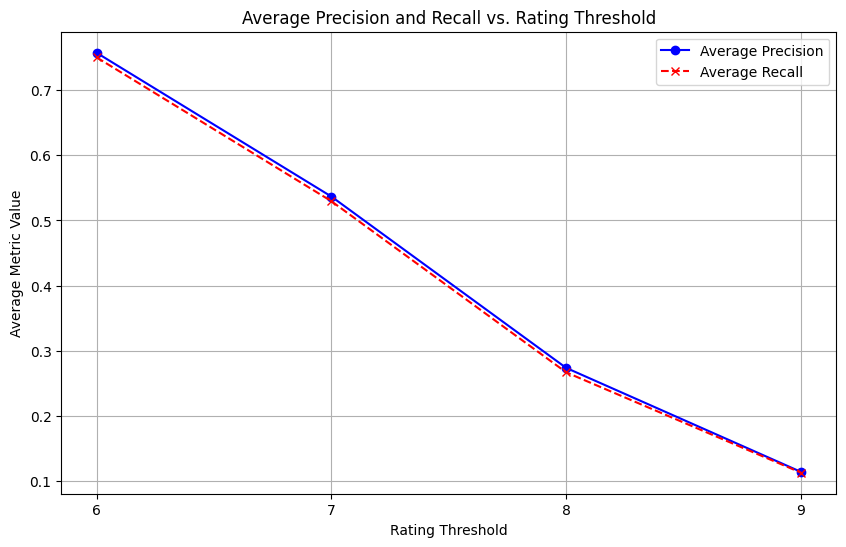

In [198]:
# Extract the thresholds and corresponding average precision and recall values
thresholds = list(average_precision_results.keys())
average_precisions = list(average_precision_results.values())
average_recalls = list(average_recall_results.values())

# Create a line chart
plt.figure(figsize=(10, 6))

# Plot precision
plt.plot(thresholds, average_precisions, marker='o', linestyle='-', color='blue', label='Average Precision')

# Plot recall
plt.plot(thresholds, average_recalls, marker='x', linestyle='--', color='red', label='Average Recall')

# Set x-axis labels and ticks to integers only
integer_thresholds = [int(threshold) for threshold in thresholds]
plt.xticks(integer_thresholds)

# Set chart labels and title
plt.xlabel('Rating Threshold')
plt.ylabel('Average Metric Value')
plt.title('Average Precision and Recall vs. Rating Threshold')

# Add a legend
plt.legend()

# Display a grid
plt.grid(True)

# Show the chart
plt.show()


### 5. Collaborative Filtering with Singular Vector Decomposition (SVD) 
#### Model Training & Evaluation

In [199]:
import pandas as pd
from sklearn.model_selection import train_test_split
from surprise import SVD, Dataset, Reader

df_svd = rating_df.copy()

# Split each user's ratings and combine
train_ratings = []
test_ratings = []

for user_id in user_with_ratings_more_than_300_less_than_500:
    user_ratings = df_svd[df_svd['user_id'] == user_id]
    # Split user's ratings using sklearn's train_test_split (e.g., 80% train, 20% test)
    train_user, test_user = train_test_split(user_ratings, test_size=0.2)
    train_ratings.append(train_user)
    test_ratings.append(test_user)

# Combine all users' splits
train_df = pd.concat(train_ratings)
test_df = pd.concat(test_ratings)

# Convert to Surprise dataset for training
reader = Reader(rating_scale=(1, 10))
train_data = Dataset.load_from_df(train_df[['user_id', 'anime_id', 'rating']], reader).build_full_trainset()

# Prepare the test set as a list of tuples for prediction
test_data = [(row.user_id, row.anime_id, row.rating) for index, row in test_df.iterrows()]

# Initialize and fit the SVD model
svd = SVD()
svd.fit(train_data)

# Make predictions on the test data
predictions = [svd.predict(uid, iid, r_ui) for (uid, iid, r_ui) in test_data]

# Print predictions
# for prediction in predictions:  # Adjust this to print as many predictions as you need
#     print(prediction)


In [200]:
# Assuming user_with_ratings_more_than_300_less_than_500 is a list or set of user IDs
# Define the range of rating thresholds you want to consider
rating_thresholds = range(6, 10)

# Initialize a dictionary to store average precision results for each threshold
average_precision_results_cf = {}
average_recall_results_cf = {}


for threshold in rating_thresholds:
    precision_results_cf = []
    recall_results_cf = []
#     intersection_count = 0

    for user_id in user_with_ratings_more_than_300_less_than_500:
        # Filter the predictions for the current user
        user_predictions = [prediction for prediction in predictions if prediction.uid == user_id]
        
         # Get anime IDs for test ratings greater than or equal to the threshold
        test_high_rating_ids = set([prediction.iid for prediction in user_predictions if prediction.r_ui >= threshold])

        # Get anime IDs for predicted ratings greater than the threshold
        predicted_high_rating_ids = set([prediction.iid for prediction in user_predictions if prediction.est >= threshold])


        # Calculate precision
        sorted_predictions = sorted(user_predictions, key=lambda x: x.est, reverse=True)
        sorted_predicted_high_rating_ids = [prediction.iid for prediction in sorted_predictions if prediction.est >= threshold]

        top_n = 10
        top_rec_ids = sorted_predicted_high_rating_ids[:top_n]
        
        precision_intersection = test_high_rating_ids.intersection(top_rec_ids)

        precision = len(precision_intersection) / top_n
        precision_results_cf.append(precision)
        
        
        
        # Calculate recall
        recall_intersection = test_high_rating_ids.intersection(predicted_high_rating_ids)
        true_pos = len(recall_intersection)
#         print(true_pos)
        num_test_high_rating = len(test_high_rating_ids)
        num_predicted_high_rating = len(predicted_high_rating_ids)
        
        recall = true_pos / num_test_high_rating if num_test_high_rating > 0 else 0
#         print(recall)
        recall_results_cf.append(recall)


#     # Calculate the average precision for the current threshold
#     average_precision = sum(precision_results_cf) / len(precision_results_cf)
#     average_precision_results_cf[threshold] = average_precision
    
#     average__recall = sum(recall_results_cf) / len(recall_results_cf)
#     average_recall_results_cf[threshold] = average_recall
    
    # Calculate the average precision and recall for the current threshold
    average_precision = sum(precision_results_cf) / len(precision_results_cf) if precision_results_cf else 0
    average_precision_results_cf[threshold] = average_precision

    average_recall = sum(recall_results_cf) / len(recall_results_cf) if recall_results_cf else 0
    average_recall_results_cf[threshold] = average_recall

    # Print statements for debugging
#     print(f"Threshold {threshold}: Average Precision = {average_precision}, Average Recall = {average_recall}")


# Print average precision results
for threshold, avg_precision in average_precision_results_cf.items():
    print(f"Threshold {threshold}: Average Precision = {avg_precision}")
    
for threshold, avg_recall in average_recall_results_cf.items():
    print(f"Threshold {threshold}: Average Recall = {avg_recall}")


Threshold 6: Average Precision = 0.9875564475664846
Threshold 7: Average Precision = 0.9542398394380379
Threshold 8: Average Precision = 0.7967385850476691
Threshold 9: Average Precision = 0.33748118414450623
Threshold 6: Average Recall = 0.9555646247642093
Threshold 7: Average Recall = 0.8167081777183036
Threshold 8: Average Recall = 0.5086551972844607
Threshold 9: Average Recall = 0.17997411639930894


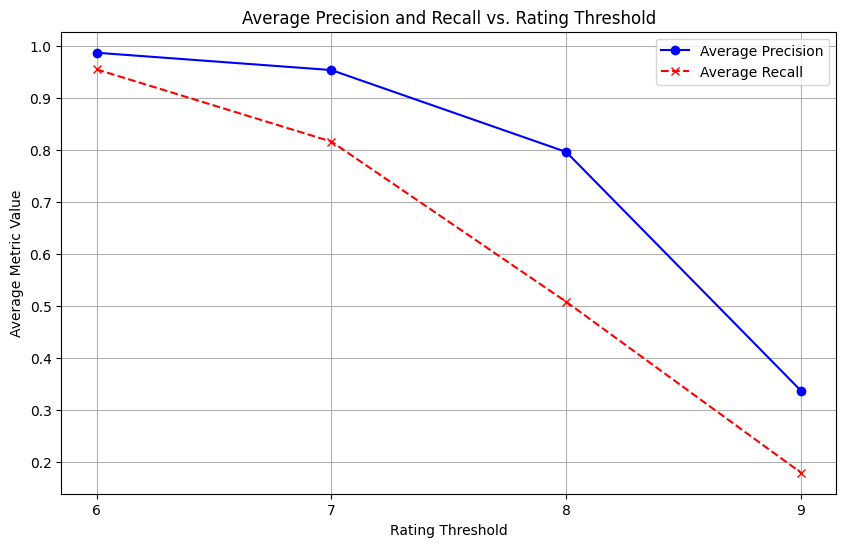

In [201]:
# Extract the thresholds and corresponding average precision and recall values
thresholds = list(average_precision_results_cf.keys())
average_precisions = list(average_precision_results_cf.values())
average_recalls = list(average_recall_results_cf.values())

# Create a line chart
plt.figure(figsize=(10, 6))

# Plot precision
plt.plot(thresholds, average_precisions, marker='o', linestyle='-', color='blue', label='Average Precision')

# Plot recall
plt.plot(thresholds, average_recalls, marker='x', linestyle='--', color='red', label='Average Recall')

# Set x-axis labels and ticks to integers only
integer_thresholds = [int(threshold) for threshold in thresholds]
plt.xticks(integer_thresholds)

# Set chart labels and title
plt.xlabel('Rating Threshold')
plt.ylabel('Average Metric Value')
plt.title('Average Precision and Recall vs. Rating Threshold')

# Add a legend
plt.legend()

# Display a grid
plt.grid(True)

# Show the chart
plt.show()


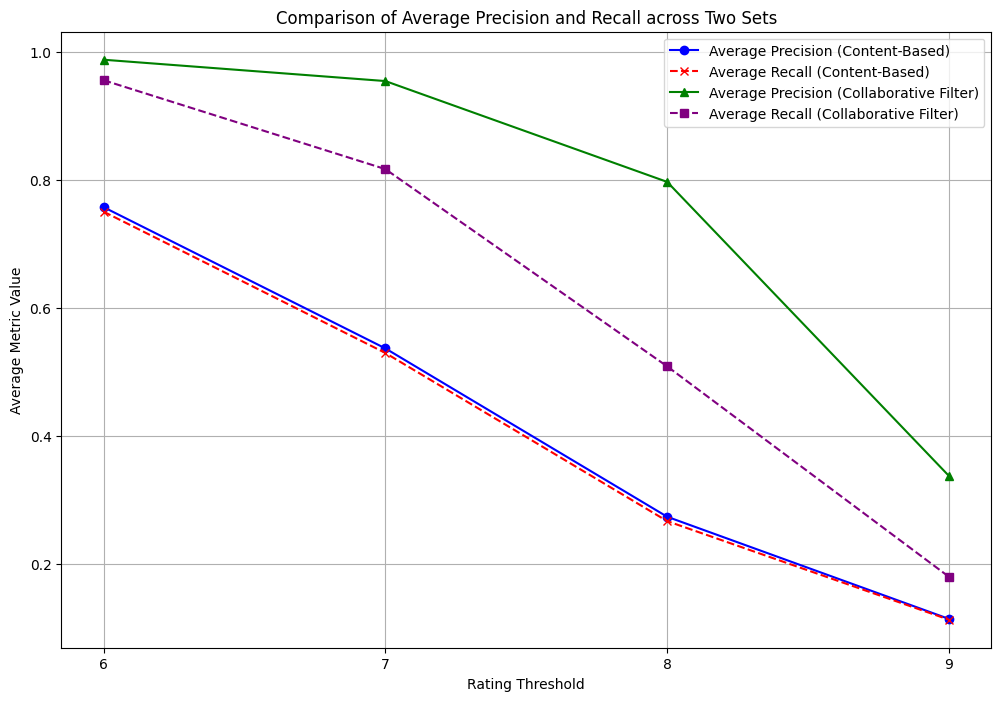

In [204]:
# Extract the thresholds and corresponding average precision and recall values
thresholds = list(average_precision_results.keys())
average_precisions = list(average_precision_results.values())
average_recalls = list(average_recall_results.values())

average_precisions_cf = list(average_precision_results_cf.values())
average_recalls_cf = list(average_recall_results_cf.values())

# Create a line chart
plt.figure(figsize=(12, 8))

# Plot precision from the first set of results
plt.plot(thresholds, average_precisions, marker='o', linestyle='-', color='blue', label='Average Precision (Content-Based)')

# Plot recall from the first set of results
plt.plot(thresholds, average_recalls, marker='x', linestyle='--', color='red', label='Average Recall (Content-Based)')

# Plot precision from the second set of results
plt.plot(thresholds, average_precisions_cf, marker='^', linestyle='-', color='green', label='Average Precision (Collaborative Filter)')

# Plot recall from the second set of results
plt.plot(thresholds, average_recalls_cf, marker='s', linestyle='--', color='purple', label='Average Recall (Collaborative Filter)')

# Set x-axis labels and ticks to integers only
integer_thresholds = [int(threshold) for threshold in thresholds]
plt.xticks(integer_thresholds)

# Set chart labels and title
plt.xlabel('Rating Threshold')
plt.ylabel('Average Metric Value')
plt.title('Comparison of Average Precision and Recall across Two Sets')

# Add a legend
plt.legend()

# Display a grid
plt.grid(True)

# Show the chart
plt.show()

### 6. Model Comparision

According to the graph shwoned above, we use the precision an recall as metrics to evaluate two models.

When we set the rating threshold to a lower value like 6, both models can achieve a rather good precision and recall results. This is because there are a large number of animes with ratings >= 6, it is easy for models to find those animes as they are everywhere!

However, as we increase the rating threshold to 8 or even 9, it gives the models challenges to find exactly the animes with ratings >= 8 or 9. As the data distribution suggests, there are very few animes meet this requirement. 

The graph suggests that Collaborative Filter gives a relatively better recommendations even under such difficult condition. Thus, we would like to use collaborative filter to give recommendations to the user.


### 7. User Evaluation

In [170]:
### 

# User 1: No preferences
user1_pref = User_Profile()
user1_recs = user1_pref.cold_start_recommend(anime_df)
print(user1_recs)


# User2: Have preferences
user2_pref = User_Profile(preferred_genres=["action", "music"], max_episodes=50)
user2_recs = user1_pref.cold_start_recommend(anime_df)
print(user2_recs)


# User 3
user3_pref = User_Profile(preferred_genres=["adventure"])
user3_recs = user3_pref.cold_start_recommend(anime_df)
print(user3_recs)


[7711, 32275, 7616, 32585, 5114, 1535, 9253, 30935, 11757, 16498]
[4224, 9253, 16498, 20, 32585, 6211, 32275, 5365, 33960, 7711]
[4098, 31829, 13789, 12807, 5249, 2467, 20907, 2311, 3811, 3355]


In [218]:
from sklearn.preprocessing import MinMaxScaler

def cos_sim(user_rated, unrated_df, top_n):
    user_rated_df = anime_df[anime_df["anime_id"].isin(user_rated)]
    user_rated_df = user_rated_df.drop(["anime_id", "name"], axis=1)
    
    unrated_df = unrated_df.drop(["anime_id", "name"], axis=1)


    # Create a MinMaxScaler instance
    scaler = MinMaxScaler()

    # Fit and transform the data
    normalized_user_df = scaler.fit_transform(user_rated_df)
    # normalized_user_df

    normalized_test_df = scaler.fit_transform(unrated_df)
    from sklearn.metrics.pairwise import cosine_similarity

    # user_interested_df_ = user_interested_df.drop(["episodes", "rating", "members"], axis=1)
    # test_df_ = test_df.drop(["episodes", "rating", "members"], axis=1)
    cosim_anime = cosine_similarity(normalized_user_df, normalized_test_df)
    
    top_indices = cosim_anime.argsort()[0][::-1][:top_n]
    
    top_recommendation_ids = unrated_df.iloc[top_indices].index.tolist()
    
    # Get the anime information for the top recommendations using the IDs
    top_recommendations_info = anime_df.loc[top_recommendation_ids]
    return top_recommendation_ids
    
#     return top_recommendations
#     return cosim_anime
#     cosim_anime

unrated_df = anime_df[~anime_df['anime_id'].isin(user2_recs)]

top_n = 10
top_recommendation_ids = cos_sim(user2_recs, unrated_df, top_n)
print(top_recommendation_ids)

top_recommendation_df = anime_uncleaned_df[anime_uncleaned_df['anime_id'].isin(top_recommendation_ids)]
print(top_recommendation_df)


# print(anime_df)
# user_update_ids = []


[493, 214, 238, 940, 1122, 29, 1620, 1660, 3579, 994]
       anime_id                                               name  \
1400         29                                             Zipang   
1796        238                                     Rekka no Honoo   
1934        940                                           Inukami!   
2695        493                          Armitage III: Poly-Matrix   
3032       1122  Pokemon Advanced Generation: Rekkuu no Houmons...   
3133       3579                                        Getter Robo   
4281       1660                             Kurogane Communication   
6756       1620                                               MAPS   
7632        994                                    Sin in the Rain   
11588       214                           Pia Carrot e Youkoso!! 2   

                                                   genre   type episodes  \
1400   Action, Drama, Historical, Military, Sci-Fi, S...     TV       26   
1796   Action, Adventur

In [224]:
user_id = 111

user_anime_df = pd.DataFrame({'user_id': [user_id] * len(top_recommendation_ids), 'anime_id': top_recommendation_ids})

# Merge with anime_df to get the ratings
user2_df = pd.merge(user_anime_df, anime_df[['anime_id', 'rating']], on='anime_id', how='left')

# Concatenate the ratings into a single string
concatenated_ratings = ', '.join(str(rating) for rating in user2_df['rating'])

print(user2_df)


   user_id  anime_id  rating
0      111       493    7.18
1      111       214    6.39
2      111       238    7.44
3      111       940    7.40
4      111      1122    7.10
5      111        29    7.56
6      111      1620    5.95
7      111      1660    6.76
8      111      3579    7.07
9      111       994    5.22


In [221]:
user2_data = [(row.user_id, row.anime_id, row.rating) for index, row in user2_df.iterrows()]

# Initialize and fit the SVD model
# svd = SVD()
# svd.fit(train_data)

# Make predictions on the test data
predictions = [svd.predict(uid, iid, r_ui) for (uid, iid, r_ui) in user2_data]



sorted_predictions = sorted(user_predictions, key=lambda x: x.est, reverse=True)
sorted_predicted_high_rating_ids = [prediction.iid for prediction in sorted_predictions if prediction.est >= 5]

top_n = 10
top_rec_ids = sorted_predicted_high_rating_ids[:top_n]

print(top_rec_ids)

for prediction in predictions:  # Adjust this to print as many predictions as you need
    print(prediction)


[572, 44, 3901, 5081, 2966, 2593, 1, 5341, 6746, 8915]
user: 111.0      item: 493.0      r_ui = 7.18   est = 7.46   {'was_impossible': False}
user: 111.0      item: 214.0      r_ui = 6.39   est = 7.56   {'was_impossible': False}
user: 111.0      item: 238.0      r_ui = 7.44   est = 7.71   {'was_impossible': False}
user: 111.0      item: 940.0      r_ui = 7.40   est = 7.45   {'was_impossible': False}
user: 111.0      item: 1122.0     r_ui = 7.10   est = 7.34   {'was_impossible': False}
user: 111.0      item: 29.0       r_ui = 7.56   est = 8.08   {'was_impossible': False}
user: 111.0      item: 1620.0     r_ui = 5.95   est = 7.32   {'was_impossible': False}
user: 111.0      item: 1660.0     r_ui = 6.76   est = 7.64   {'was_impossible': False}
user: 111.0      item: 3579.0     r_ui = 7.07   est = 7.84   {'was_impossible': False}
user: 111.0      item: 994.0      r_ui = 5.22   est = 7.12   {'was_impossible': False}


In [225]:
# Assuming 'predictions' is a list of predictions made by the SVD model
sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)

# Extract the anime IDs from the sorted predictions and get the top 5
# Ensuring the IDs are treated as integers
top_5_predicted_ids = [int(prediction.iid) for prediction in sorted_predictions[:5]]

print("Top 5 Anime IDs:", top_5_predicted_ids)


Top 5 Anime IDs: [29, 3579, 238, 1660, 214]


In [227]:
# Display info of the top 5 animes in the ranking result

top_5_rec_df = anime_uncleaned_df[anime_uncleaned_df['anime_id'].isin(top_5_predicted_ids)]
top_5_rec_df

,anime_id,name,genre,type,episodes,rating,members
1400,29,Zipang,"Action, Drama, Historical, Military, Sci-Fi, S...",TV,26,7.56,8630
1796,238,Rekka no Honoo,"Action, Adventure, Martial Arts, Shounen, Supe...",TV,42,7.44,35258
3133,3579,Getter Robo,"Action, Mecha, Sci-Fi, Shounen",TV,51,7.07,2938
4281,1660,Kurogane Communication,"Action, Adventure, Drama, Sci-Fi",TV,24,6.76,2928
11588,214,Pia Carrot e Youkoso!! 2,"Comedy, Hentai, Romance",OVA,3,6.39,1408


### 8. User Feedback

#### Content

Recommended animes from the system can be quite rigid sometimes, since some of the old classic animes are popular and has been highly rated by many users, thus these animes will appear in the recommendation list with very high frequency (too main stream, not personalised), which can lead to a lack of diversity in the anime suggestions.

### 9. Future Enhancements: 

#### Dateset
Our first step towards improvement should involve acquiring a more detailed dataset that includes more detailed attributes for each anime. Alternatively, it might be possible to integrate an API to fetch in-depth metadata, such as succinct plot summaries, from online sources could be added to the anime.csv file, which might be able to enhance our content-based model significantly.

Furthermore, enhancing the user rating datasets by adding user-specific information would be helpful as well (although this can be challenging due to privacy concerns), but it do give users more personalized recommendations.

Additionally,  a 'timestamp' column in the user ratings, indicating the exact date and time of watching and rating an anime, would allow for more precise anime recommendations. This feature could leverage trends in anime popularity over different periods to give user another filter option.


#### Model
Introducing a random seed in certain parts of the code can be beneficial, particularly when aiming to provide users with unexpected or less common recommendations. This approach can increase the diversity of the suggested animes, especially by including animes that may have been watched or rated by fewer users. It's an effective way to break the monotony of frequently recommended popular animes.

Since we are using a subset to train the model instead of using the original dataset, the final performance of the models might be negatively affected. It would be better if we use the unsampled dataset to improve the model generalisation and robustness.

